In [1]:
%matplotlib inline

In [108]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

import statsmodels.api as sm

import pydotplus
from IPython.display import Image

import re
from textblob import TextBlob

In [3]:
plt.style.use('ggplot')

In [4]:
infile = r'C:\Users\Jorg Frese\Dropbox\projects\textio\ya.csv'

In [5]:
df_ya = pd.read_csv(infile)

### initial observations
    - only 3 authors with more than 1 title, so will do analysis at title level
    - titles can be from a series, but the rest of the series not necessarily in the data
    - only 100 records, so can't go overboard with number of features
    - are there synonyms: "Chelsea M. Cameron vs. Chelsea M. Campbell", "E. K. Johnston vs. E. Katherine Kottaras"

### candidate features
    1. is the title part of a series?
    2. acronym in author name?
    3. sentiment of title (after removing explanatory part of title)
    4. length of the title

In [7]:
def series(a_string):
    p = re.compile(r'(?:Book|Vol.?)\s(?:One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|\d+)\b', re.I)
    nums = p.findall(a_string)
    if len(nums)==0:
        return 'standalone'
    elif len(re.findall(r'One|1', nums[0], re.I))>0:
        return 'first'
    else:
        return 'sequel'

In [102]:
def seriesv2(a_string):
    p = re.compile(r'(?:Book|Vol.?)\s(?:One|Two|Three|Four|Five|Six|Seven|Eight|Nine|Ten|\d+)\b', re.I)
    nums = p.findall(a_string)
    if len(nums)==0:
        return 'standalone'
    else:
        return 'series'

In [22]:
def acronym(a_string):
    p = re.compile(r'^[A-Z]\.')
    if len(p.findall(a_string)) > 0:
        return 1
    else:
        return 0

In [41]:
def trim_title(a_string):
    try:
        isx = re.search(r"\(", a_string).start()
        new_string = a_string[:isx]
    except:
        new_string =  a_string
    try:
        isx = re.search(r":", new_string).start()
        new_string2 = new_string[:isx]
    except:
        new_string2 =  new_string   
    return new_string2

In [135]:
df_ya['success'] = df_ya.apply(lambda x: int((x['Star rating']>=4.5) & (x['Number of reviews']>=100)), axis=1)
df_ya['series'] = df_ya['Book title'].apply(seriesv2)
df_ya['acronym'] = df_ya['Author name'].apply(acronym)
df_ya['title_trimmed'] = df_ya['Book title'].apply(trim_title)
df_ya['sent'] = df_ya['title_trimmed'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_ya['core_title_length'] = df_ya['title_trimmed'].apply(lambda x: len(x))
df_ya['amazon'] = df_ya['Publisher'].apply(lambda x: int(x.strip() == 'Amazon'))

In [136]:
df_ya['success'].mean()

0.27

In [137]:
df_ya.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 14 columns):
Book title           100 non-null object
Author name          100 non-null object
Star rating          100 non-null float64
Number of reviews    100 non-null int64
Length               100 non-null int64
Publisher            100 non-null object
series               100 non-null object
acronym              100 non-null int64
no_paren             100 non-null object
title_trimmed        100 non-null object
sent                 100 non-null float64
core_title_length    100 non-null int64
amazon               100 non-null int64
success              100 non-null int64
dtypes: float64(2), int64(6), object(6)
memory usage: 11.0+ KB


In [138]:
df_ya['series'].value_counts()

standalone    83
series        17
Name: series, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001F437CF0A20>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000001F435F50F28>]], dtype=object)

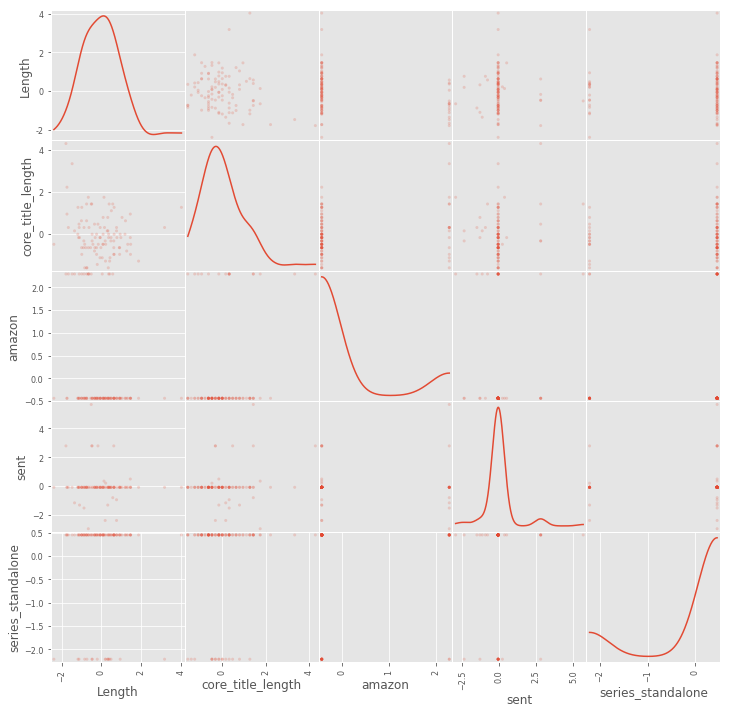

In [150]:
depVar = ['success']
indepVars = ['Length','core_title_length','series','amazon','sent']

df_yX = df_ya[depVar+indepVars]

y = df_yX[depVar[0]]
X = df_yX.drop(depVar[0], 1)

X = pd.get_dummies(X, drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X = pd.DataFrame(X_scaled, columns=X.columns)

scatter_matrix(X, alpha=0.2, figsize=(12, 12), diagonal='kde')

In [151]:
X['intercept'] = 1.0

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model score:  0.636363636364


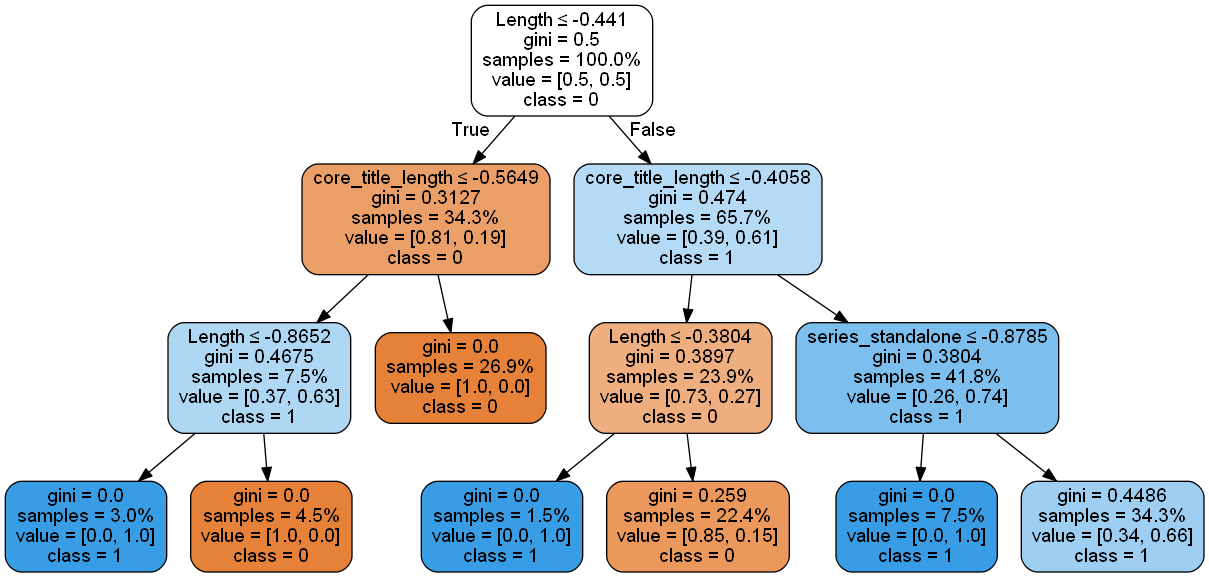

In [152]:
dtclf = tree.DecisionTreeClassifier(max_depth=3, class_weight='balanced').fit(X_train,y_train)
print("model score: ", dtclf.score(X_test,y_test))

dot_data = tree.export_graphviz(dtclf,
                                out_file=None,
                                feature_names=X_train.columns,
                                class_names=['0','1'],
                                filled=True,
                                rounded=True,
                                proportion=True,
                                special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

model score:  0.727272727273


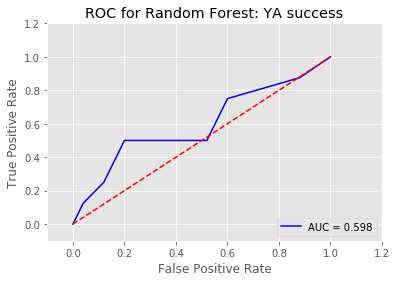

In [153]:
rfclf = RandomForestClassifier(class_weight='balanced')
rfclf = rfclf.fit(X_train,y_train)
print("model score: ", rfclf.score(X_test,y_test))

probs = rfclf.predict_proba(X_test)

fpr,tpr,th = roc_curve(y_test.values,probs[:,1])
roc_auc = auc(fpr,tpr)

plt.title('ROC for Random Forest: YA success')
plt.plot(fpr,tpr,'b',label='AUC = %0.3f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [154]:
logit = sm.Logit(y_train.astype('int'), X_train.astype('int'))
# fit the model
result = logit.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.579223
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                success   No. Observations:                   67
Model:                          Logit   Df Residuals:                       61
Method:                           MLE   Df Model:                            5
Date:                Fri, 30 Jun 2017   Pseudo R-squ.:                 0.02865
Time:                        16:29:11   Log-Likelihood:                -38.808
converged:                       True   LL-Null:                       -39.952
                                        LLR p-value:                    0.8079
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Length                0.1706      0.358      0.477      0.633      -0.530       0.872
core_tit